<h1><center>ASHRAE - Great Energy Predictor III - DataWrangling💡</center></h1>

# Table of Contents

* [Introduction](#Intro)
* [Libraries](#Lib)
* [Data (CSV) files](#data)

# Introduction <a class="anchor" id="Intro"></a>
I have always been passionate about ways in which we can better our energy consumptions. 
Hence this project as my first Datascience project makes complete sense. 
Time to save the environment 🌎

This dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.


# Libraries 📚 <a class="anchor" id="Lib"></a>

In [3]:
import numpy as np
import pandas as pd

import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def percentage_null(df):
    return (df.isnull().sum()/df.count().max()*100).sort_values()

# Data (CSV) files <a class="anchor" id="data"></a>

**Created directory structure for the project using cookiecutter**

In [5]:
%%time
file_dir = "../data/raw/"
train_df = pd.read_csv(file_dir + "train.csv")
building_metadata_df = pd.read_csv(file_dir + "building_metadata.csv")
weather_test_df = pd.read_csv(file_dir + "weather_test.csv")
weather_train_df = pd.read_csv(file_dir + "weather_train.csv")
test_df = pd.read_csv(file_dir + "test.csv")
sample_submission_df = pd.read_csv(file_dir + "sample_submission.csv")
!ls ../data/raw

ashrae-energy-prediction.zip train.csv
building_metadata.csv        weather_test.csv
sample_submission.csv        weather_train.csv
test.csv
CPU times: user 27.1 s, sys: 7.69 s, total: 34.8 s
Wall time: 39.3 s


In [15]:
# site -0 correction
site_0_bids = building_metadata_df[building_metadata_df.site_id == 0].building_id.unique()
train_df.loc[(train_df.building_id.isin(site_0_bids)) & (train_df.meter==0), 'meter_reading'] = train_df[(train_df.building_id.isin(site_0_bids)) & (train_df.meter==0)]['meter_reading'] * 0.2931

**Save Files as Feather files for fast loading.**

In [16]:
%%time
train_df.to_feather("../data/interim/train.feather")
test_df.to_feather("../data/interim/test.feather")
weather_train_df.to_feather("../data/interim/weather_train.feather")
weather_test_df.to_feather("../data/interim/weather_test.feather")
building_metadata_df.to_feather("../data/interim/building_metadata.feather")
sample_submission_df.to_feather("../data/interim/sample_submission.feather")

**Load from feather files for fast loading**

In [17]:
%%time
train_df = pd.read_feather("../data/interim/train.feather")
test_df = pd.read_feather("../data/interim/test.feather")
weather_train_df = pd.read_feather("../data/interim/weather_train.feather")
weather_test_df = pd.read_feather("../data/interim/weather_test.feather")
building_metadata_df = pd.read_feather("../data/interim/building_metadata.feather")
sample_submission_df = pd.read_feather("../data/interim/sample_submission.feather")

CPU times: user 5.83 s, sys: 13.5 s, total: 19.3 s
Wall time: 45.7 s


### Check sizes of the different dfs

In [18]:
print('train_df size is {} & memory used is {:.2f}Mb\nbuilding_metadata_df size is {} & memory used is {:.2f}Mb\
\nweather_test_df size is{} & memory used is {:.2f}Mb\nweather_train_df size is {} & memory used is {:.2f}Mb\
\ntest_df size is {} & memory used is {:.2f}Mb\nsample_submission_df size is{} & memory used is {:.2f}Mb'.\
      format(train_df.shape,train_df.memory_usage().sum()/1024**2,
             building_metadata_df.shape,building_metadata_df.memory_usage().sum()/1024**2,
             weather_test_df.shape,weather_test_df.memory_usage().sum()/1024**2,
             weather_train_df.shape,weather_train_df.memory_usage().sum()/1024**2,
            test_df.shape,test_df.memory_usage().sum()/1024**2,
             sample_submission_df.shape,sample_submission_df.memory_usage().sum()/1024**2))

train_df size is (20216100, 4) & memory used is 616.95Mb
building_metadata_df size is (1449, 6) & memory used is 0.07Mb
weather_test_df size is(277243, 9) & memory used is 19.04Mb
weather_train_df size is (139773, 9) & memory used is 9.60Mb
test_df size is (41697600, 4) & memory used is 1272.51Mb
sample_submission_df size is(41697600, 2) & memory used is 636.26Mb


### Train df 

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


**Meter category - {0:Electtricity,1:ChilledWater,2:Steam,3:HotWater}**

In [13]:
train_df.meter.unique()

array([0, 3, 1, 2])

**Meter column should be of the dtype Category**

In [7]:
train_df['meter'] = train_df['meter'].astype('category')

**timestamp column should be of the dtype timestamp and not str**

In [8]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int64         
 1   meter          category      
 2   timestamp      datetime64[ns]
 3   meter_reading  float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 482.0 MB


In [10]:
if train_df.building_id.max() < np.iinfo(np.int16).max and train_df.building_id.min() > np.iinfo(np.int16).min:
    print("building_id can be converted to int16 instead of int64")

building_id can be converted to int16 instead of int64


In [11]:
train_df['building_id'] = train_df['building_id'].astype('int16')

In [12]:
train_df.agg([min,"mean","median",max]).T

,min,mean,median,max
building_id,0,799.278,895,1448
timestamp,2016-01-01 00:00:00,2016-07-03 22:59:40.301601792,NaT,2016-12-31 23:00:00
meter_reading,0,2117.12,78.775,2.19047e+07


**For meter_reading since the median is ~78 , there are some outliers at the higher range.**

In [13]:
#train_df_report = train_df.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=True)
#train_df_report
#Did not find profiling very useful for this dataset

#train_df_profile_report = train_df.profile_report(html={'style': {'full_width': True}})
#train_df_profile_report.to_file("../reports/train_df_profile_report.html")

### building_metadata_df

In [14]:
building_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [15]:
building_metadata_df.agg([min,"mean","median",max]).T

,min,mean,median,max
site_id,0,6.95238,5,15
building_id,0,724,724,1448
primary_use,Education,NaN,NaN,Warehouse/storage
square_feet,283,92111.8,57673,875000
year_built,1900,1967.96,1970,2017
floor_count,1,3.74085,3,26


In [16]:
building_metadata_df['site_id'] = building_metadata_df['site_id'].astype('int16')

In [17]:
building_metadata_df['building_id'] = building_metadata_df['building_id'].astype('int16')

In [18]:
building_metadata_df.primary_use.unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

**Primary use column should be of type category**

In [19]:
building_metadata_df['primary_use'] = building_metadata_df['primary_use'].astype('category')

**#Convert Year to Datetime format for better time-series-analysis**

In [20]:
#building_metadata_df['year_built']=building_metadata_df['year_built'].astype(str)
#building_metadata_df['year_built']=building_metadata_df['year_built'].str.rstrip(".0")
#building_metadata_df['year_built']=pd.to_datetime(building_metadata_df['year_built'],infer_datetime_format=True,errors='coerce')

### weather_train_df

In [21]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [22]:
weather_train_df['site_id'] = weather_train_df['site_id'].astype('int16')

In [23]:
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])

In [24]:
weather_train_df.agg([min,"mean","median",max]).T

,min,mean,median,max
site_id,0,7.47898,7,15
timestamp,2016-01-01 00:00:00,2016-07-02 07:17:57.942092032,NaT,2016-12-31 23:00:00
air_temperature,-28.9,14.4181,15,47.2
cloud_coverage,0,2.14931,2,9
dew_temperature,-35,7.35016,8.3,26.1
precip_depth_1_hr,-1,0.983047,0,343
sea_level_pressure,968.2,1016.16,1016.4,1045.5
wind_direction,0,180.527,190,360
wind_speed,0,3.56053,3.1,19


# Missing Data analysis

> **building_metadata_df**

<Figure size 144x144 with 0 Axes>

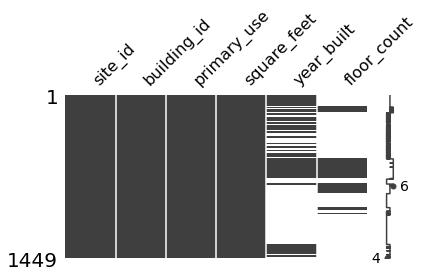

In [25]:
import missingno as msno
plt.figure(figsize=(2, 2))
msno_mat=msno.matrix(building_metadata_df.sort_values("site_id"),figsize=(6,3))

**Check the percentage null values for floor_count and year_built per site**

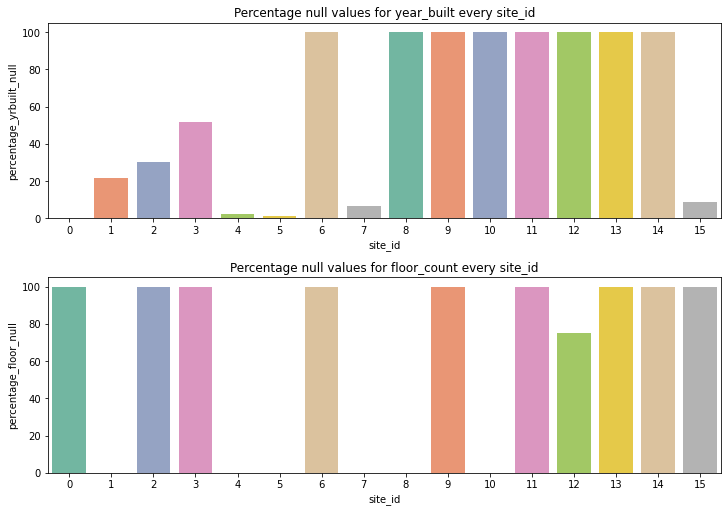

In [26]:
fig,axs = plt.subplots(2,1,figsize=(10, 7),constrained_layout=True)
bg_grpby = building_metadata_df.groupby(by=['site_id'])

yr_built_null = bg_grpby[['year_built']].apply(lambda x : x.isnull().sum()/len(x)*100).round(4)\
                .rename(columns={'year_built':'percentage_yrbuilt_null'})
#yr_built_null = yr_built_null[yr_built_null.percentage_yrbuilt_null.notnull() & yr_built_null.percentage_yrbuilt_null > 0].sort_values(by='percentage_yrbuilt_null')
sns.barplot(data=yr_built_null,x=yr_built_null.index,y="percentage_yrbuilt_null",palette="Set2",ax=axs[0])

bg_flrnull = bg_grpby[['floor_count']].apply(lambda x : x.isnull().sum()/len(x)*100).round(4)\
                .rename(columns={'floor_count':'percentage_floor_null'})
#bg_flrnull = bg_flrnull[bg_flrnull.percentage_floor_null.notnull() & bg_flrnull.percentage_floor_null > 0].sort_values(by='percentage_floor_null')
sns.barplot(data=bg_flrnull,x=bg_flrnull.index,y="percentage_floor_null",palette="Set2",ax=axs[1])

_= axs[0].set_title("Percentage null values for year_built every site_id")
_= axs[1].set_title("Percentage null values for floor_count every site_id")

**Only for site id 12 can we infer some information from other buildings . <br>
Rest all sites have either null values for all buildings or none at all.<br><br>
Since too many buildings have year_built NaN we are going to leave the column as is.<br>
Same is the case with floor_count**

> **weather_train_df**

In [29]:
#Make sure no duplicate entries for site and timestamp
weather_train_df[['site_id','timestamp']].duplicated().sum()

0

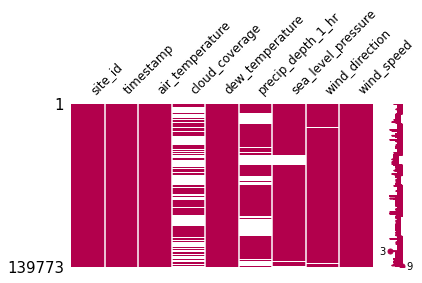

In [30]:
import missingno as msno
msno_mat=msno.matrix(weather_train_df,figsize=(6,3),fontsize=12,color=(0.7,0.0,0.3))

**Check the percentage null values for precip_depth_1_hr and cloud_coverage per site**

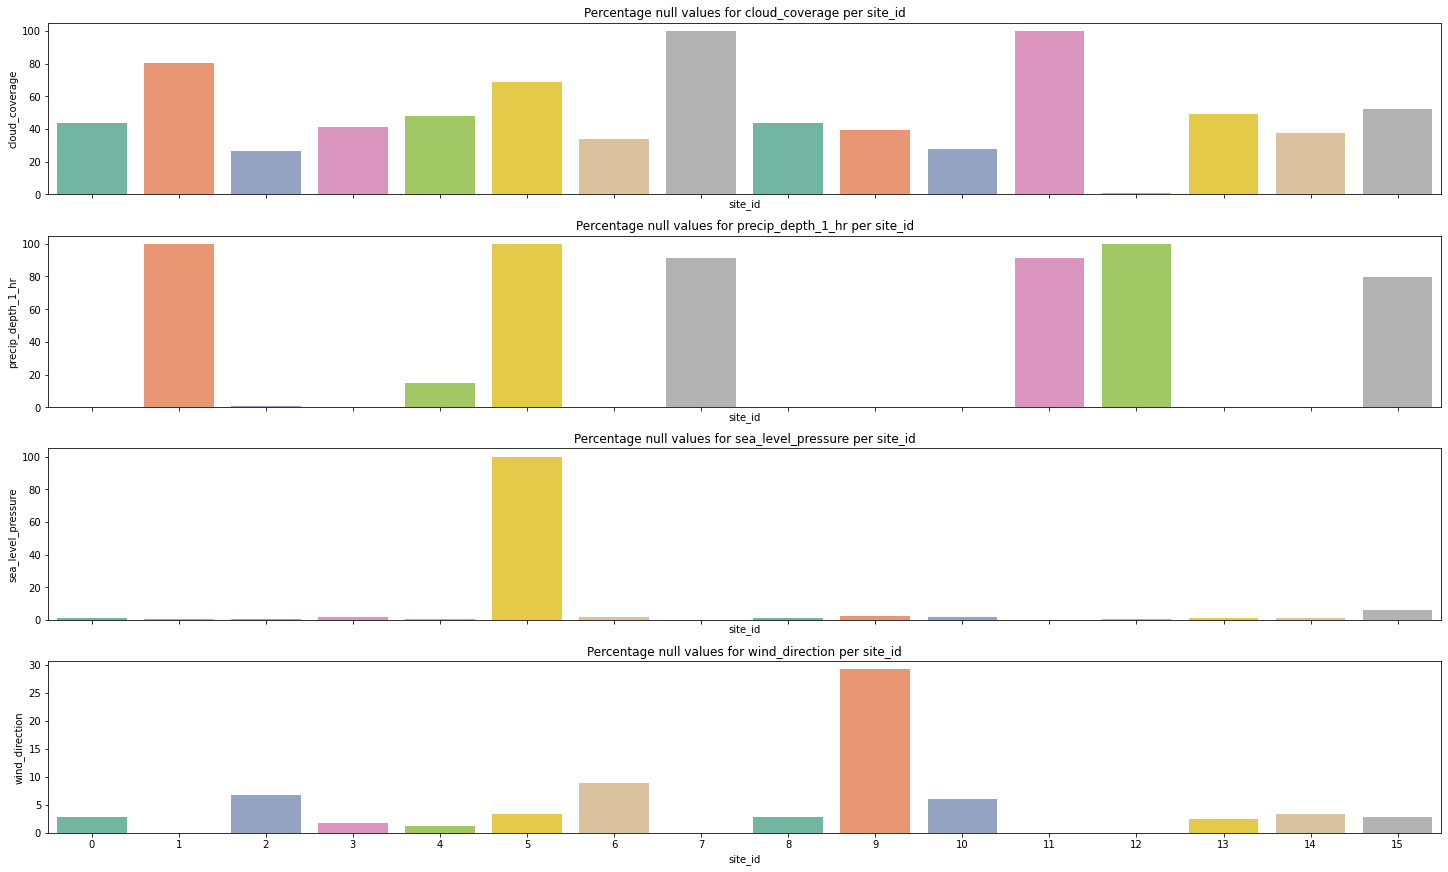

In [32]:
cols=weather_train_df.columns[~weather_train_df.columns.isin(['site_id','timestamp','air_temperature','dew_temperature','wind_speed'])]
fig, axs = plt.subplots(len(cols),1,figsize=(20,len(cols)*3),constrained_layout=True,sharex=True)
for ax in fig.get_axes():
    ax.label_outer()
wt_grpby = weather_train_df.groupby(by=['site_id'])

for i,col in enumerate(cols):
    yr_built_null = wt_grpby[[col]].apply(lambda x : x.isnull().sum()/len(x)*100).round(4)
    _=sns.barplot(data=yr_built_null,x=yr_built_null.index,y=col,\
                palette="Set2",ax=axs[i])
    _= axs[i].set_title("Percentage null values for " + col + " per site_id")

# Removing outliers 

**train_df**

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          category      
 2   timestamp      datetime64[ns]
 3   meter_reading  float64       
dtypes: category(1), datetime64[ns](1), float64(1), int16(1)
memory usage: 366.3 MB


[None]

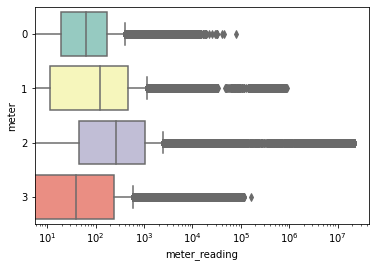

In [34]:
meter_rd_boxplt = sns.boxplot(data=train_df,x="meter_reading",y="meter",palette="Set3")
meter_rd_boxplt.set(xscale="log")

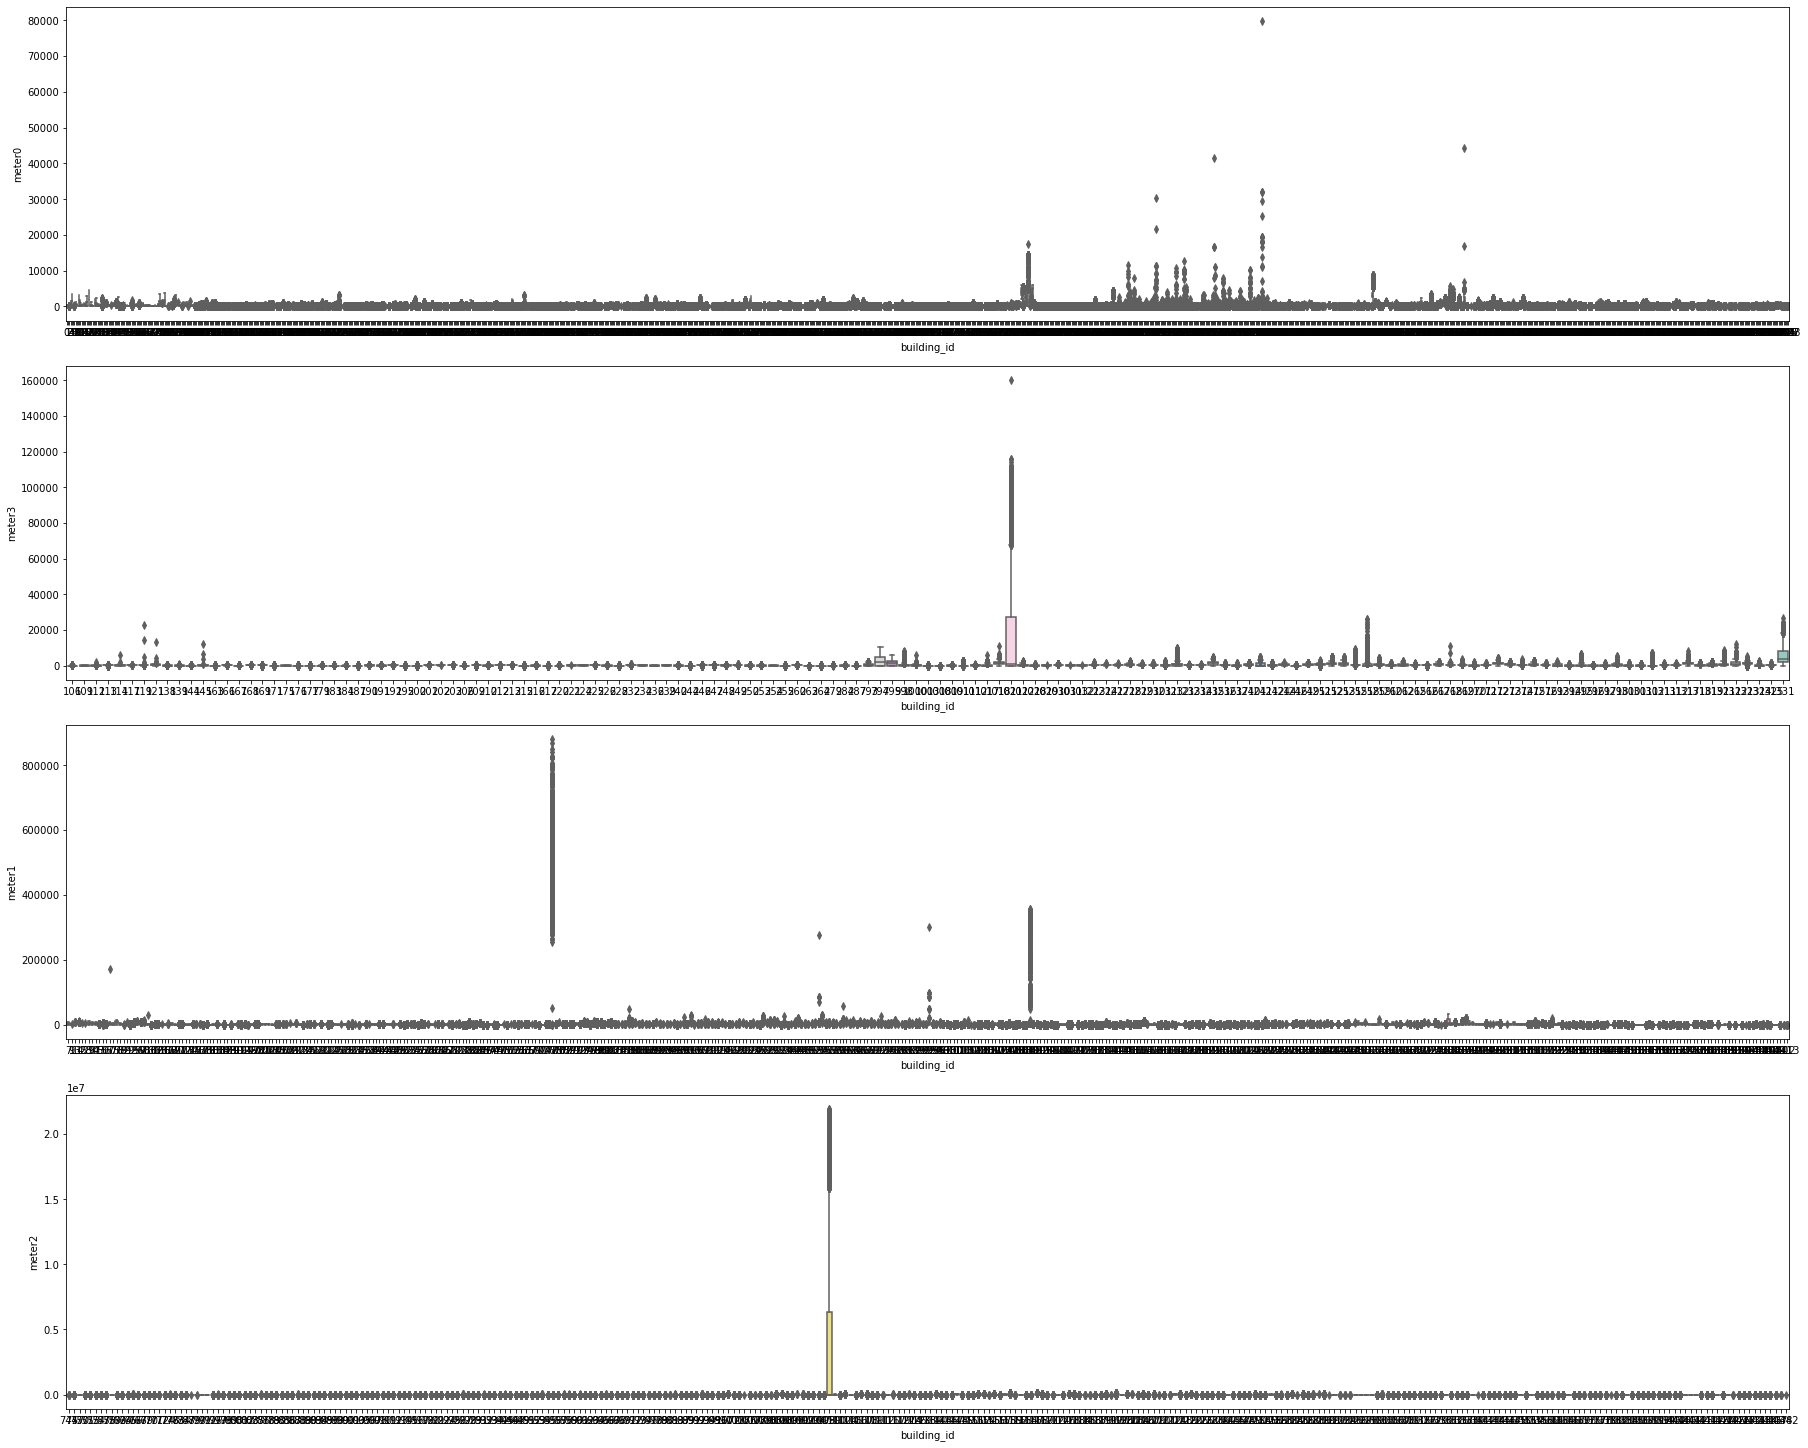

In [35]:
fig, axs = plt.subplots(4,1, figsize=(25, 20),constrained_layout=True)
for i,meter_type in enumerate(train_df.meter.unique()):
    _df = train_df[train_df.meter==meter_type]
    meter_rd_boxplt = sns.boxplot(data=_df,x="building_id",y="meter_reading",palette="Set3",ax=axs[i])
    meter_rd_boxplt.set_ylabel("meter" + str(meter_type))

**There are some clear outliers for meter0 , that is electricity . <br>
Lets find out which building it is**

In [36]:
train_df[(train_df.meter==0) & (train_df.meter_reading > 40000)]

,building_id,meter,timestamp,meter_reading
4689615,1168,0,2016-03-30 09:00:00,44336.5
15975198,954,0,2016-10-17 07:00:00,41552.0
15975226,993,0,2016-10-17 07:00:00,79769.0


In [37]:
train_df.drop(train_df.loc[(train_df.meter==0) & (train_df.meter_reading > 40000)].index,inplace=True)

**There are some clear outliers for meter3 , that is hotwater . <br>
Lets find out which building it is**

In [38]:
train_df.loc[(train_df.meter==3) & (train_df.meter_reading > 120000)]

,building_id,meter,timestamp,meter_reading
19730988,1021,3,2016-12-23 10:00:00,160187.0


In [39]:
train_df.drop(train_df.loc[(train_df.meter==3) & (train_df.meter_reading > 120000)].index,inplace=True)

In [40]:
train_df.loc[(train_df.meter==2) & (train_df.meter_reading > 20000000)]

,building_id,meter,timestamp,meter_reading
3096856,1099,2,2016-02-27 20:00:00,20392200.0
3098934,1099,2,2016-02-27 21:00:00,20154200.0
3534117,1099,2,2016-03-07 13:00:00,20128200.0
3576101,1099,2,2016-03-08 09:00:00,20812000.0
3578205,1099,2,2016-03-08 10:00:00,21316400.0
...,...,...,...,...
9069340,1099,2,2016-06-16 06:00:00,20482500.0
9076373,1099,2,2016-06-16 09:00:00,20464600.0
17276974,1099,2,2016-11-09 10:00:00,21162700.0
17284060,1099,2,2016-11-09 13:00:00,21821700.0


In [41]:
building_metadata_df[building_metadata_df.building_id==1099]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1099,13,1099,Education,332884,NaN,NaN


In [42]:
for meter_type in sorted(train_df.meter.unique()):
    _df = train_df[train_df.meter==meter_type][['meter_reading']]
    Q1 = _df.quantile(0.25)
    Q3 = _df.quantile(0.75)
    IQR = Q3 - Q1
    outliers_df = _df[((_df < (Q1 - 1.5 * IQR)) |(_df > (Q3 + 1.5 * IQR))).any(axis=1)]
    print("Percentage outliers for train_df meter type {}={:.2f}%".\
      format(meter_type,(len(outliers_df)/len(_df))*100))

Percentage outliers for train_df meter type 0=10.73%
Percentage outliers for train_df meter type 1=11.17%
Percentage outliers for train_df meter type 2=12.54%
Percentage outliers for train_df meter type 3=12.72%


In [52]:
for meter_type in sorted(train_df.meter.unique()):
    _df = train_df[train_df.meter==meter_type][['meter_reading']]
    _mean = _df.mean()
    _std = _df.std()
    upper_lim = _mean + _std * 3
    lower_lim = _mean - _std * 3
    outliers_df = train_df[(_df > upper_lim) | (_df < lower_lim)]

    print("Percentage outliers for train_df meter type {}={:.2f}%".\
      format(meter_type,(len(outliers_df)/len(_df))*100))

Percentage outliers for train_df meter type 0=167.62%
Percentage outliers for train_df meter type 1=483.36%
Percentage outliers for train_df meter type 2=746.34%
Percentage outliers for train_df meter type 3=1599.33%


**As the percentage outliers is more than 10% we will not remove them.**

> **weather_train_df**

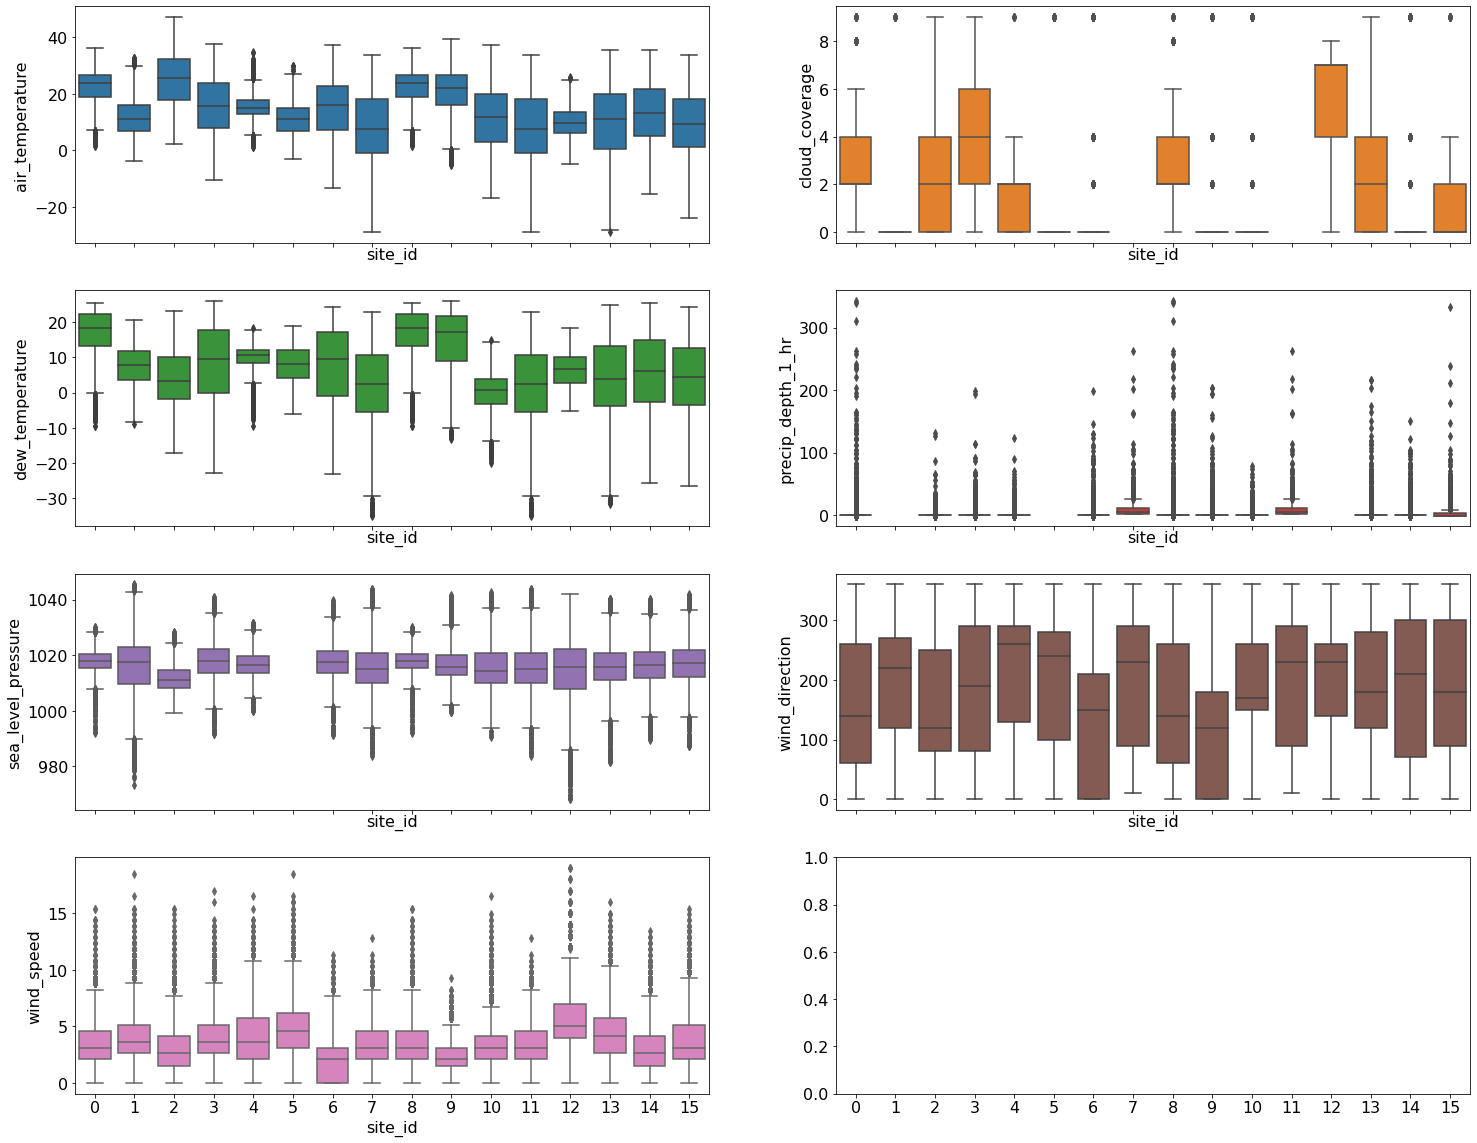

In [44]:
import itertools
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(4,2, figsize=(25, 20),sharex='col')
axs= axs.ravel()
palette = itertools.cycle(sns.color_palette())
for i in range(7):
    sns.boxplot(x='site_id',y=weather_train_df.columns[i+2],data=weather_train_df,ax=axs[i],color=next(palette))

**Looks like we are dealing with sparse data in wind_speed and percip_depth_1hr.<br>
sparsity = count zero elements / total elements**

In [45]:
sparsity_precip=((weather_train_df['precip_depth_1_hr']==0).sum()/len(weather_train_df)*100).round(4)
print("Precipitation depth per 1hr is {}% sparse".format(sparsity_precip))

Precipitation depth per 1hr is 55.7404% sparse


In [46]:
#Lets work with columns with possible outliers (Remove site_id,timestamp)
cols=['air_temperature','dew_temperature','cloud_coverage','wind_speed']
_df = weather_train_df[cols]
Q1 = _df.quantile(0.25)
Q3 = _df.quantile(0.75)
IQR = Q3 - Q1
outliers_df = _df[((_df < (Q1 - 1.5 * IQR)) |(_df > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Percentage outliers for {}={:.2f}%".\
      format(cols,(len(outliers_df)/len(weather_train_df))*100))

Percentage outliers for ['air_temperature', 'dew_temperature', 'cloud_coverage', 'wind_speed']=2.52%


In [47]:
#weather_train_df=weather_train_df.loc[~weather_train_df.index.isin(outliers_df.index)]

# Convert to timeseries and Interpolate missing data

> **weather_train_df**

**Lets convert weather_train_df to timeseries and observe the data with monthly re-sampling**

In [53]:
weather_ts_df = weather_train_df.set_index(['timestamp','site_id'])

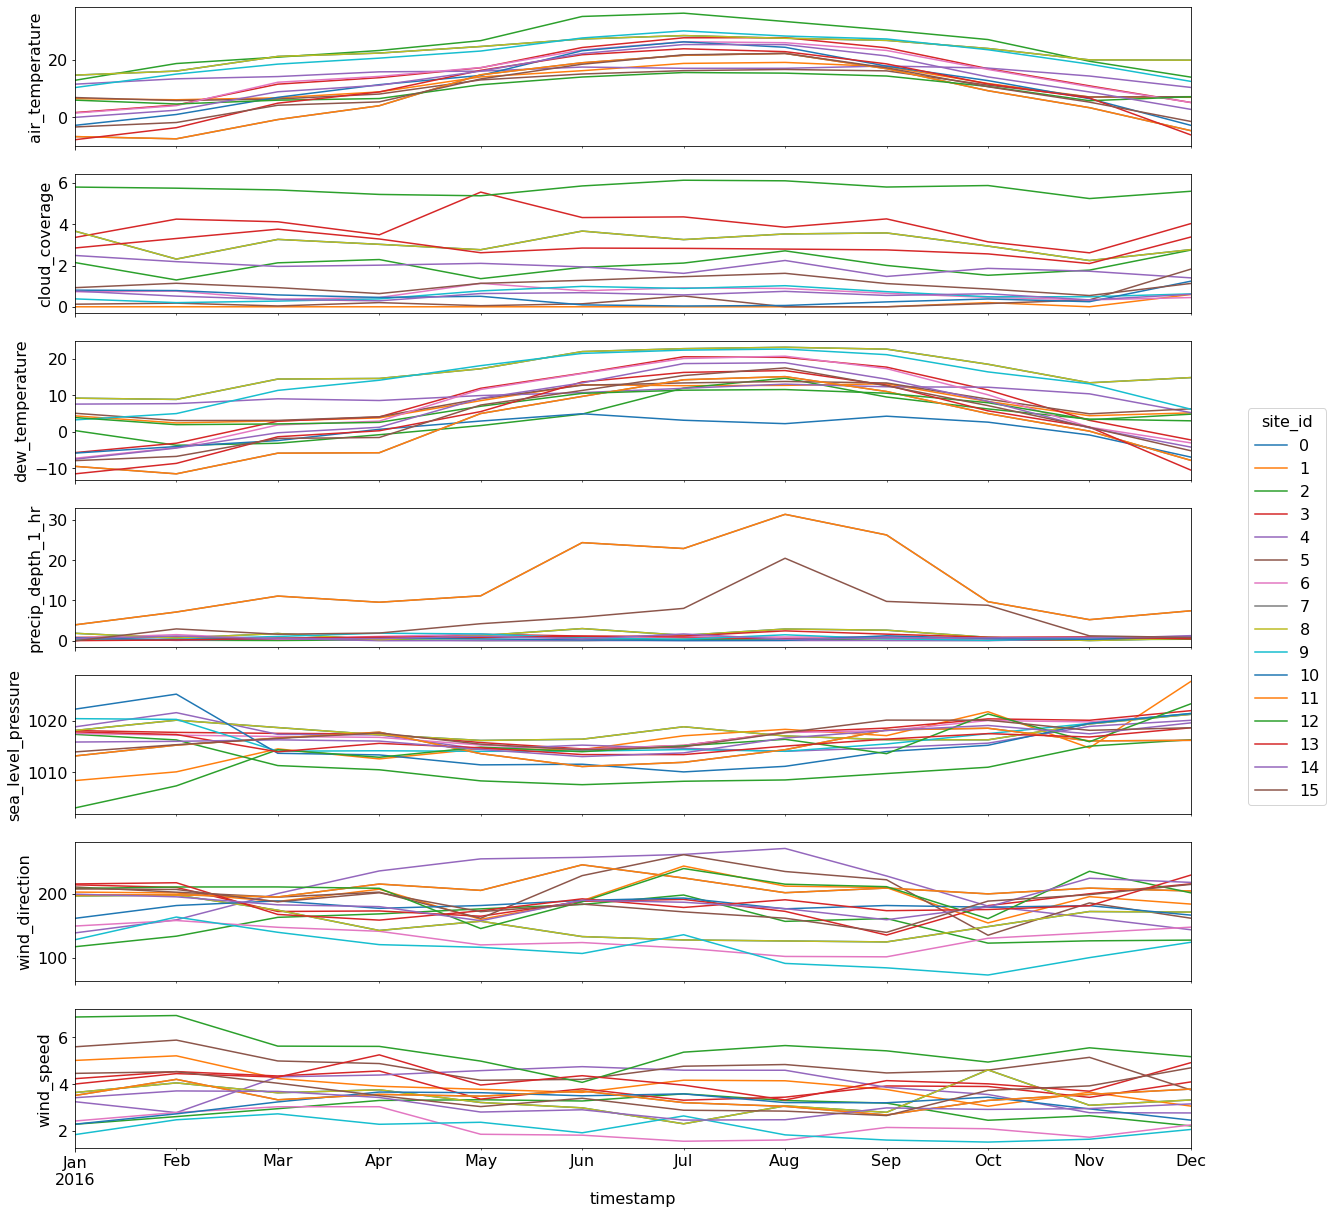

In [49]:
cols=weather_ts_df.columns
fig, ax = plt.subplots(len(cols),1,figsize=(20,len(cols)*3),sharex=True)

for i,col in enumerate(cols):
    _ = weather_ts_df[col].unstack().resample('M').mean().plot(ax=ax[i],legend=False)
    ax[i].set_ylabel(col)
    handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels,title="site_id", loc='right')

**Let's analyse the fluctuation over a day**


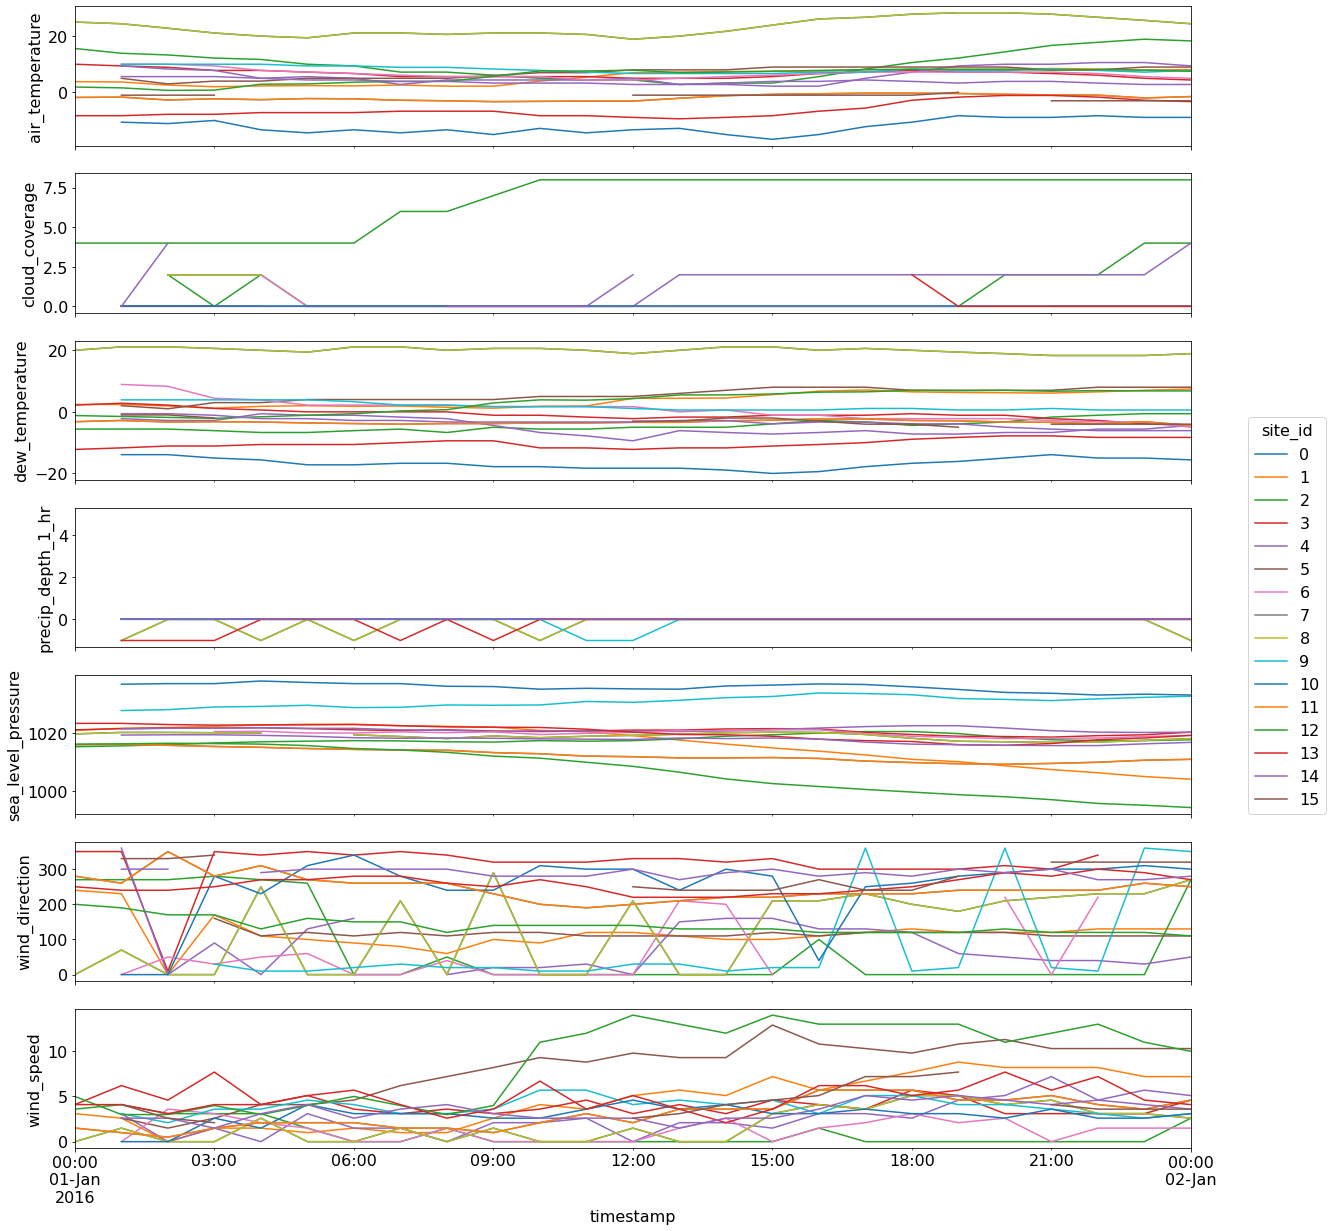

In [50]:
cols=weather_ts_df.columns
fig, ax = plt.subplots(len(cols),1,figsize=(20,len(cols)*3),sharex=True)

for i,col in enumerate(cols):
    _ = weather_ts_df[col].unstack()['2016-01-01 00:00:00':'2016-01-02 00:00:00'].resample('H').mean().plot(ax=ax[i],legend=False)
    ax[i].set_ylabel(col)
    handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels,title="site_id", loc='right')

In [77]:
print("Percentage null values for the weather_train_df:\n{}".format(percentage_null(weather_train_df)))

Percentage null values for the weather_train_df:
site_id                0.000000
timestamp              0.000000
air_temperature        0.039350
dew_temperature        0.080845
wind_speed             0.217496
wind_direction         4.484414
sea_level_pressure     7.596603
precip_depth_1_hr     35.979052
cloud_coverage        49.489529
dtype: float64


In [78]:
per_null=percentage_null(weather_ts_df.unstack())
print("site_ids in weather_train_df with 100% null values:\n{}".format(per_null[per_null==100]))

site_ids in weather_train_df with 100% null values:
                    site_id
precip_depth_1_hr   1          100.0
cloud_coverage      7          100.0
precip_depth_1_hr   5          100.0
                    12         100.0
sea_level_pressure  5          100.0
cloud_coverage      11         100.0
dtype: float64


**We can interpolate the values linearly to fill NAN values**

In [82]:
weather_ts_df=weather_ts_df.unstack().interpolate(limit_direction='both')
per_null=percentage_null(weather_ts_df)
print("site_ids in weather_train_df with 100% null values after interpolation:\n{}".format(per_null[per_null==100]))

site_ids in weather_train_df with 100% null values after interpolation:
                    site_id
precip_depth_1_hr   5          100.0
sea_level_pressure  5          100.0
precip_depth_1_hr   12         100.0
                    1          100.0
cloud_coverage      7          100.0
                    11         100.0
dtype: float64


In [87]:
weather_ts_df=weather_ts_df.stack()
print("Percentage null values for the weather_train_df:\n{}".format(percentage_null(weather_ts_df)))

Percentage null values for the weather_train_df:
air_temperature        0.00
dew_temperature        0.00
wind_direction         0.00
wind_speed             0.00
sea_level_pressure     6.25
cloud_coverage        12.50
precip_depth_1_hr     18.75
dtype: float64


> **train_df**

**Lets convert train_df to timeseries**